Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ccs_df = pd.read_csv('/home/lbarbut/data/ccs/METLIN_IMS_all plot CV %3C2% _dimers.csv')
ccs_df

Molecule Name Molecular Formula  \
0      3-[3-(2,3-dihydroindol-1-yl)propyl]-1-[(4-fluo...        C19H22FN3O   
1      3-{[1,1'-biphenyl]-4-ylmethylidene}-6-fluoro-2...        C22H15FO3S   
2      1-{[3-(4-methoxyphenyl)-1,2,4-oxadiazol-5-yl]m...        C25H28N4O3   
3      3-[2-oxo-2-(4-phenylmethanesulfonylpiperazin-1...       C22H30N4O5S   
4      2-{[1,1'-biphenyl]-2-ylamino}-1-(morpholin-4-y...        C18H20N2O2   
...                                                  ...               ...   
65283                                                NaN               NaN   
65284                                                NaN               NaN   
65285                                                NaN               NaN   
65286                                                NaN               NaN   
65287                                                NaN               NaN   

       METLIN ID Precursor Adduct    CCS1    CCS2    CCS3  CCS_AVG  % CV  \
0      1181481.0    328.1820[M+H]  176.63  176.63  176.63   176.63   0.0   
1      1191359.0    379.0799[M+H]  192.26  192.26  192.26   192.26   0.0   
2      1228206.0    433.2234[M+H]  211.12  211.12  211.12   211.12   0.0   
3      1176932.0    463.2010[M+H]  204.22  204.22  204.22   204.22   0.0   
4      1183857.0    297.1598[M+H]  174.47  174.47  174.47   174.47   0.0   
...          ...              ...     ...     ...     ...      ...   ...   
65283        NaN              NaN     NaN     NaN     NaN      NaN   NaN   
65284        NaN              NaN     NaN     NaN     NaN      NaN   NaN   
65285        NaN              NaN     NaN     NaN     NaN      NaN   NaN   
65286        NaN              NaN     NaN     NaN     NaN      NaN   NaN   
65287        NaN              NaN     NaN     NaN     NaN      NaN   NaN   

            m/z  ...     m/z.1       Dimer  Dimer.1 dimer line    CCS  m/z.2  \
0      328.1820  ...  328.1820  209.886594  Monomer        NaN  135.0   50.0   
1      379.0799  ...  379.0799  223.588309  Monomer        NaN  310.0  700.0   
2      433.2234  ...  433.2234  238.163739  Monomer        NaN    NaN    NaN   
3      463.2010  ...  463.2010  246.233709  Monomer        NaN    NaN    NaN   
4      297.1598  ...  297.1598  201.535418  Monomer        NaN    NaN    NaN   
...         ...  ...       ...         ...      ...        ...    ...    ...   
65283       NaN  ...       NaN         NaN      NaN        NaN    NaN    NaN   
65284       NaN  ...       NaN         NaN     3825        NaN    NaN    NaN   
65285       NaN  ...       NaN         NaN    61457        NaN    NaN    NaN   
65286       NaN  ...       NaN         NaN      NaN        NaN    NaN    NaN   
65287       NaN  ...       NaN         NaN    65282        NaN    NaN    NaN   

        pubChem                                              inchi  \
0      25345055  InChI=1S/C19H22FN3O/c20-17-8-6-15(7-9-17)14-22...   
1           NaN  InChI=1S/C22H15FO3S/c23-19-10-11-21-20(13-19)2...   
2      17541371  InChI=1S/C25H28N4O3/c1-31-21-10-8-19(9-11-21)2...   
3      16295966  InChI=1S/C22H30N4O5S/c27-19(16-26-20(28)22(23-...   
4      17463671  InChI=1S/C18H20N2O2/c21-18(20-10-12-22-13-11-2...   
...         ...                                                ...   
65283        --                                                 --   
65284        --                                                 --   
65285        --                                                 --   
65286        --                                                 --   
65287        --                                                 --   

                                                  smiles  \
0                    O=C(NCc1ccc(cc1)F)NCCCN1CCc2c1cccc2   
1      Fc1ccc2c(c1)C(=O)C(=Cc1ccc(cc1)c1ccccc1)CS2(=O)=O   
2      COc1ccc(cc1)c1noc(n1)CN1CCN(CC1)C(=O)C1(CCC1)c...   
3      O=C(N1CCN(CC1)S(=O)(=O)Cc1ccccc1)CN1C(=O)NC2(C...   
4                        O=C(N1CCOCC1)CNc1ccccc1c1ccccc1   
...                            

Debug Mode

In [3]:
debug_mode = False
if debug_mode:
    # Keep only the first 1000 rows
    ccs_df = ccs_df.iloc[:1000]

    # Reset the index (optional)
    ccs_df = ccs_df.reset_index(drop=True)


Data Preprocessing

In [4]:
# drop NaN Precusor Adduct rows
ccs_df = ccs_df.dropna(subset=['Precursor Adduct'])

# remove the m/z number before the Precursor Adduct since the info is also in m/z column
ccs_df.loc[:, 'Precursor Adduct'] = ccs_df['Precursor Adduct'].str.replace(r'[0-9.]+', '', regex=True)

# remove [M+Na] rows
ccs_df = ccs_df[ccs_df['Precursor Adduct'] != '[M+Na]']

# change [M+H] to [M+H]+ and [M-H] to [M-H]-
ccs_df["Precursor Adduct"] = ccs_df["Precursor Adduct"].replace({
    "[M+H]": "[M+H]+",
    "[M-H]": "[M-H]-"
})

In [5]:
print(ccs_df['Precursor Adduct'].value_counts())

Precursor Adduct
[M+H]+    28136
[M-H]-    19697
Name: count, dtype: int64


In [6]:
from rdkit import Chem

In [7]:
def is_valid_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles) is not None  # True if valid, False if invalid
    except Exception:
        return False


In [8]:

# # drop smiles strings of '--'
# ccs_df = ccs_df[ccs_df["smiles"] != "--"]

# Apply validation
ccs_df["smiles_is_valid"] = ccs_df["smiles"].apply(is_valid_smiles)

invalid_smiles = ccs_df.loc[~ccs_df["smiles_is_valid"], "smiles"]  # Select invalid SMILES
# print("Invalid SMILES strings:")
# print(invalid_smiles.tolist())

# Filter out invalid SMILES
ccs_df = ccs_df[ccs_df["smiles_is_valid"]].drop(columns=["smiles_is_valid"]).reset_index(drop=True)

[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error while parsing: --
[16:57:07] SMILES Parse Error: Failed parsing SMILES '--' for input: '--'
[16:57:07] SMILES Parse Error: syntax error whil

In [9]:
# drop NaN CCS_AVG rows
ccs_df = ccs_df.dropna(subset=['CCS_AVG'])
ccs_df.shape
ccs_df

Molecule Name Molecular Formula  \
0      3-[3-(2,3-dihydroindol-1-yl)propyl]-1-[(4-fluo...        C19H22FN3O   
1      3-{[1,1'-biphenyl]-4-ylmethylidene}-6-fluoro-2...        C22H15FO3S   
2      1-{[3-(4-methoxyphenyl)-1,2,4-oxadiazol-5-yl]m...        C25H28N4O3   
3      3-[2-oxo-2-(4-phenylmethanesulfonylpiperazin-1...       C22H30N4O5S   
4      2-{[1,1'-biphenyl]-2-ylamino}-1-(morpholin-4-y...        C18H20N2O2   
...                                                  ...               ...   
44402  2-oxo-2-(piperidin-1-yl)ethyl 4-(dimethylamino...        C16H22N2O3   
44403  3-(4-hydroxyphenyl)-2-{5H,6H,7H,8H,9H-[1,2,4]t...         C16H16N4O   
44404  2-oxo-2-(piperidin-1-yl)ethyl 1-benzyl-3-(pyri...        C23H24N4O3   
44405  3-(7-methoxy-4-methyl-2-oxochromen-3-yl)-N-(3-...         C19H25NO4   
44406  2-{[5-(2H-1,3-benzodioxol-5-yl)-1,3,4-oxadiazo...       C15H17N3O4S   

       METLIN ID Precursor Adduct    CCS1    CCS2    CCS3  CCS_AVG      % CV  \
0      1181481.0           [M+H]+  176.63  176.63  176.63   176.63  0.000000   
1      1191359.0           [M+H]+  192.26  192.26  192.26   192.26  0.000000   
2      1228206.0           [M+H]+  211.12  211.12  211.12   211.12  0.000000   
3      1176932.0           [M+H]+  204.22  204.22  204.22   204.22  0.000000   
4      1183857.0           [M+H]+  174.47  174.47  174.47   174.47  0.000000   
...          ...              ...     ...     ...     ...      ...       ...   
44402  1104361.0           [M-H]-  177.40  184.26  178.97   180.21  1.994438   
44403  1175562.0           [M-H]-  172.96  167.05  172.96   170.99  1.995520   
44404  1104315.0           [M-H]-  198.31  191.19  197.54   195.68  1.996866   
44405  1116367.0           [M-H]-  182.66  176.41  182.66   180.58  1.998250   
44406  1103036.0           [M-H]-  180.88  181.47  187.50   183.28  1.998929   

            m/z  ...     m/z.1       Dimer  Dimer.1 dimer line    CCS  m/z.2  \
0      328.1820  ...  328.1820  209.886594  Monomer        NaN  135.0   50.0   
1      379.0799  ...  379.0799  223.588309  Monomer        NaN  310.0  700.0   
2      433.2234  ...  433.2234  238.163739  Monomer        NaN    NaN    NaN   
3      463.2010  ...  463.2010  246.233709  Monomer        NaN    NaN    NaN   
4      297.1598  ...  297.1598  201.535418  Monomer        NaN    NaN    NaN   
...         ...  ...       ...         ...      ...        ...    ...    ...   
44402  289.1558  ...  289.1558  199.380741  Monomer        NaN    NaN    NaN   
44403  279.1251  ...  279.1251  196.680477  Monomer        NaN    NaN    NaN   
44404  403.1776  ...  403.1776  230.075410  Monomer        NaN    NaN    NaN   
44405  330.1711  ...  330.1711  210.422060  Monomer        NaN    NaN    NaN   
44406  334.0867  ...  334.0867  211.476140  Monomer        NaN    NaN    NaN   

        pubChem                                              inchi  \
0      25345055  InChI=1S/C19H22FN3O/c20-17-8-6-15(7-9-17)14-22...   
1           NaN  InChI=1S/C22H15FO3S/c23-19-10-11-21-20(13-19)2...   
2      17541371  InChI=1S/C25H28N4O3/c1-31-21-10-8-19(9-11-21)2...   
3      16295966  InChI=1S/C22H30N4O5S/c27-19(16-26-20(28)22(23-...   
4      17463671  InChI=1S/C18H20N2O2/c21-18(20-10-12-22-13-11-2...   
...         ...                                                ...   
44402   2372645  InChI=1S/C16H22N2O3/c1-17(2)14-8-6-13(7-9-14)1...   
44403   4459718  InChI=1S/C16H16N4O/c17-11-13(10-12-5-7-14(21)8...   
44404   4788420  InChI=1S/C23H24N4O3/c28-21(26-12-5-2-6-13-26)1...   
44405       NaN  InChI=1S/C19H25NO4/c1-11(2)13(4)20-18(21)9-8-1...   
44406   4805118  InChI=1S/C15H17N3O4S/c1-3-18(4-2)13(19)8-23-15...   

                                                  smiles  \
0                    O=C(NCc1ccc(cc1)F)NCCCN1CCc2c1cccc2   
1      Fc1ccc2c(c1)C(=O)C(=Cc1ccc(cc1)c1ccccc1)CS2(=O)=O   
2      COc1ccc(cc1)c1noc(n1)CN1CCN(CC1)C(=O)C1(CCC1)c...   
3      O=C(N1CCN(CC1)S(=O)(=O)Cc1ccccc1)CN1C(=O)NC2(C...   
4                        O=C(N1CCOCC1)CNc1c

In [10]:
ccs_df["Instrument_type"] = "timsTOF"

In [11]:
ccs_df['CE'] = -1

In [12]:
# Create Metabolite column

from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

CE_upper_limit = 100.0
weight_upper_limit = 1000.0

ccs_df["Metabolite"] = ccs_df["smiles"].apply(Metabolite)
ccs_df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

ccs_df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))

# df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
# ccs_df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
# ccs_df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

[16:57:14] WARNING: not removing hydrogen atom without neighbors
[16:57:14] WARNING: not removing hydrogen atom without neighbors
[16:57:14] WARNING: not removing hydrogen atom without neighbors
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] WARNING: Omitted undefined stereo

[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGenerator
[16:57:14] DEPRECATION WARNING: please use MorganGe

0        None
1        None
2        None
3        None
4        None
         ... 
44402    None
44403    None
44404    None
44405    None
44406    None
Name: Metabolite, Length: 44407, dtype: object

In [13]:
print("Assign unique metabolite identifiers.")
print("Unique smiles: " + str(len(ccs_df["smiles"].unique())))

metabolite_id_map = {}
for metabolite in ccs_df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.set_id(id)
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite

ccs_df["group_id"] = ccs_df["Metabolite"].apply(lambda x: x.get_id())
ccs_df["num_per_group"] = ccs_df["group_id"].map(ccs_df["group_id"].value_counts())

for i, data in ccs_df.iterrows():
    data["Metabolite"].set_loss_weight(1.0 / data["num_per_group"])
ccs_df["loss_weight"] = ccs_df["Metabolite"].apply(lambda x: x.loss_weight)
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

def print_df_stats(df):
    num_spectra = df.shape[0]
    num_ids = len(df["group_id"].unique())
    
    print(f"Dataframe stats: {num_spectra} spectra covering {num_ids} unique structures")

print_df_stats(ccs_df)

Assign unique metabolite identifiers.
Unique smiles: 27334
Found 27326 unique molecular structures.
Dataframe stats: 44407 spectra covering 27326 unique structures


In [14]:
ccs_df.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
44402    None
44403    None
44404    None
44405    None
44406    None
Length: 44407, dtype: object

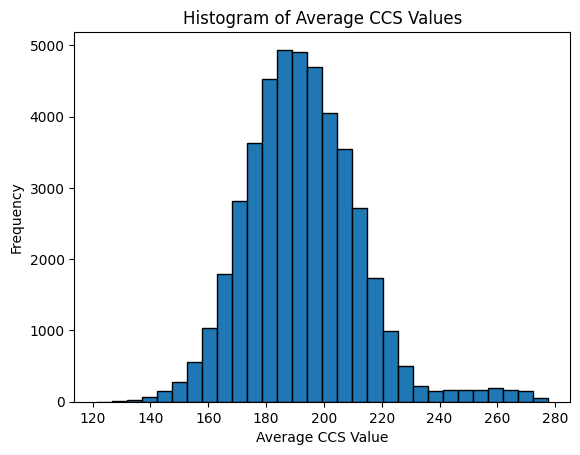

In [15]:
# Plot histogram of CCS_AVG column

plt.hist(ccs_df['CCS_AVG'], bins=30, edgecolor='black')
plt.xlabel('Average CCS Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average CCS Values')
plt.show()

Predict CCS Values

In [16]:
import json
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

In [17]:
# Load best model

dev="cuda:1"
#MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth6_Jan24.pt"
MODEL_PATH = "/home/lbarbut/models/ccs_models/v0.0.1_merged_depth6_Aug24_sqrt+CCS+RT_drop3.pt" # New sqrt model (improved)

try:
    model = GNNCompiler.load_from_state_dict(MODEL_PATH)
    print("Model loaded from state dict without errors.")
except:
    raise NameError("Error: Failed loading from state dict.")
        

model.eval()
model = model.to(dev)

model.model_params

Model loaded from state dict without errors.


{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument'],
 'training_label': 'compiled_probsALL',
 'rt_supported': True,
 'ccs_supported': True}

In [18]:
spectral_modules = ["node_embedding", "edge_embedding", "GNN_module", "edge_module", "precursor_module", "RT_module"]


for module in spectral_modules:
    model.freeze_submodule(module)

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires gradients")
    # else:
    #     print(f"{name}: does not require gradients (frozen)")

CCS_module.dense_layers.0.weight: requires gradients
CCS_module.dense_layers.0.bias: requires gradients
CCS_module.dense_layers.1.weight: requires gradients
CCS_module.dense_layers.1.bias: requires gradients
CCS_module.output_layer.weight: requires gradients
CCS_module.output_layer.bias: requires gradients


In [20]:
metadata_key = { "collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "m/z", 
                 'precursor_mode': "Precursor Adduct",
                 }

ccs_df["summary"] = ccs_df.apply(lambda x: {key: x[name] for key, name in metadata_key.items()}, axis=1)
ccs_df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
ccs_df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

geo_data = ccs_df["Metabolite"].apply(lambda x: x.as_geometric_data(with_labels=False).to(dev)).values

Prediction

In [21]:
fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)
fiora.pred_all(ccs_df, model)


KeyboardInterrupt: 

In [53]:
ccs_df['CCS_pred'] = ccs_df["Metabolite"].apply(lambda x: x.CCS_pred)

In [54]:
ccs_df['CCS_pred']

0        tensor(191.9466, device='cuda:1')
1        tensor(191.9459, device='cuda:1')
2        tensor(208.1397, device='cuda:1')
3        tensor(213.6994, device='cuda:1')
4        tensor(171.2999, device='cuda:1')
                       ...                
44402    tensor(176.8240, device='cuda:1')
44403    tensor(176.7797, device='cuda:1')
44404    tensor(202.7449, device='cuda:1')
44405    tensor(192.2687, device='cuda:1')
44406    tensor(188.1292, device='cuda:1')
Name: CCS_pred, Length: 44407, dtype: object

Measure MSE of predicted and experimental values

In [55]:
mse = 0

mse = ((ccs_df['CCS_AVG'] - ccs_df['CCS_pred'].apply(lambda x: x.item()))**2).mean()
print(mse)


253.72799446061387


Plot Experimental CCS vs. Predicted CCS

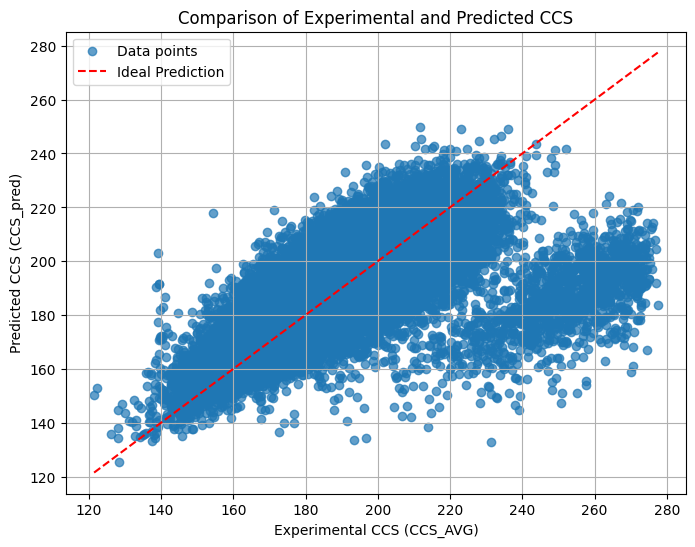

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(ccs_df['CCS_AVG'], ccs_df['CCS_pred'].apply(lambda x: x.item()), alpha=0.7, label="Data points") #alpha:transparency
plt.plot([ccs_df['CCS_AVG'].min(), ccs_df['CCS_AVG'].max()],
         [ccs_df['CCS_AVG'].min(), ccs_df['CCS_AVG'].max()],
         color='red', linestyle='--', label="Ideal Prediction")

plt.xlabel("Experimental CCS (CCS_AVG)")
plt.ylabel("Predicted CCS (CCS_pred)")
plt.title("Comparison of Experimental and Predicted CCS")
plt.legend()
plt.grid()
plt.show()

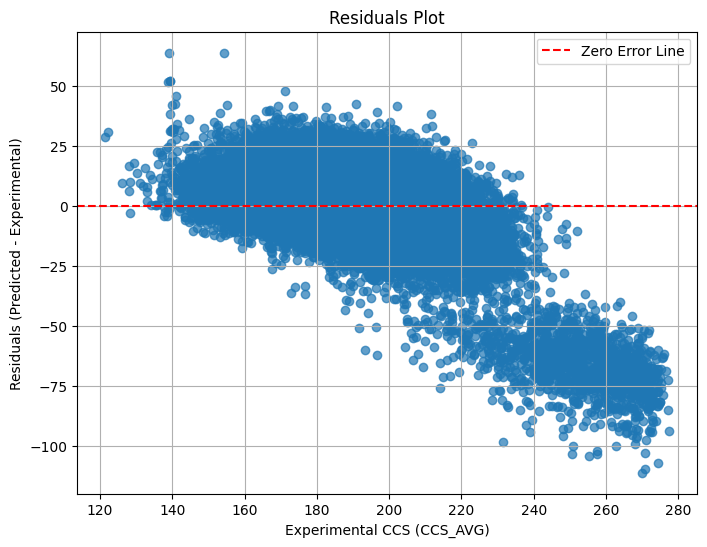

In [57]:
plt.figure(figsize=(8, 6))
residuals = ccs_df['CCS_pred'].apply(lambda x: x.item()) - ccs_df['CCS_AVG']
plt.scatter(ccs_df['CCS_AVG'], residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label="Zero Error Line")

plt.xlabel("Experimental CCS (CCS_AVG)")
plt.ylabel("Residuals (Predicted - Experimental)")
plt.title("Residuals Plot")
plt.legend()
plt.grid()
plt.show()

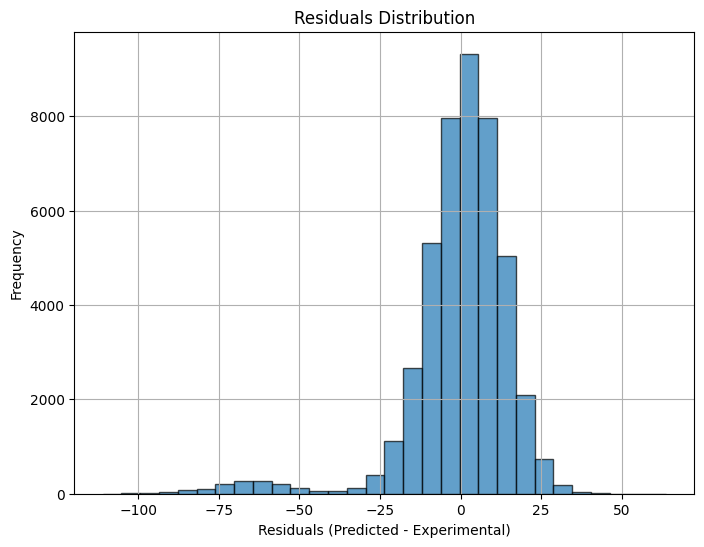

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')

plt.xlabel("Residuals (Predicted - Experimental)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid()
plt.show()

In [59]:
from sklearn.metrics import r2_score

# Berechnung des R²-Werts
r2 = r2_score(ccs_df['CCS_AVG'], ccs_df['CCS_pred'].apply(lambda x: x.item()))
print(f"R²-Wert: {r2}")

R²-Wert: 0.35290587574369325


In [60]:
ccs_df['error'] = (ccs_df['CCS_AVG'] - ccs_df['CCS_pred'].apply(lambda x: x.item())).abs()

# 100 biggest deviation
largest_errors_df = ccs_df.nlargest(100, 'error')
print("Größte Abweichungen:")
print(largest_errors_df[['CCS_AVG', 'CCS_pred', 'error']])

Größte Abweichungen:
       CCS_AVG                           CCS_pred       error
36656   270.05  tensor(158.9468, device='cuda:1')  111.103192
36608   270.69  tensor(161.2299, device='cuda:1')  109.460081
38889   274.48  tensor(167.1784, device='cuda:1')  107.301564
32956   255.17  tensor(150.8709, device='cuda:1')  104.299089
32336   257.59  tensor(154.0916, device='cuda:1')  103.498371
...        ...                                ...         ...
13340   246.72  tensor(163.4458, device='cuda:1')   83.274230
37774   257.49  tensor(174.2220, device='cuda:1')   83.268015
39892   274.06  tensor(190.8424, device='cuda:1')   83.217639
36922   272.35  tensor(189.1557, device='cuda:1')   83.194330
1558    264.20  tensor(181.1316, device='cuda:1')   83.068439

[100 rows x 3 columns]


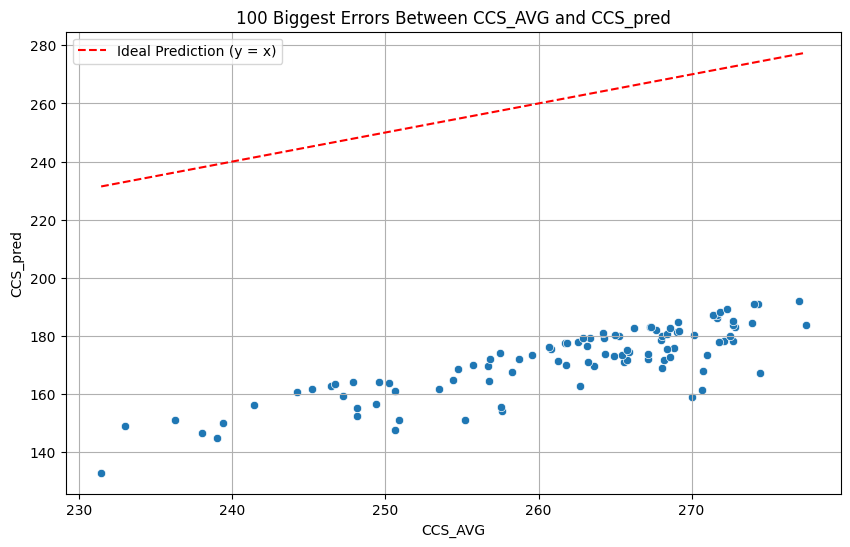

In [61]:
# not a very interpretable plot

import seaborn as sns

ccs_pred_values = largest_errors_df['CCS_pred'].apply(lambda x: x.item())

plt.figure(figsize=(10, 6))

# Scatter plot of the CCS_AVG vs. CCS_pred
sns.scatterplot(data=largest_errors_df, x='CCS_AVG', y=ccs_pred_values)
plt.plot([largest_errors_df['CCS_AVG'].min(), largest_errors_df['CCS_AVG'].max()],
         [largest_errors_df['CCS_AVG'].min(), largest_errors_df['CCS_AVG'].max()],
         color='red', linestyle='--', label="Ideal Prediction (y = x)")
# Titles and labels
plt.title("100 Biggest Errors Between CCS_AVG and CCS_pred")
plt.xlabel("CCS_AVG")
plt.ylabel("CCS_pred")
plt.legend()
plt.grid()

plt.show()

In [62]:
# R² for M+H and M-H seperately
for mode in ['[M+H]+', '[M-H]-']:
    mode_df = ccs_df[ccs_df['Precursor Adduct'] == mode]
    r2_mode = r2_score(mode_df['CCS_AVG'], mode_df['CCS_pred'].apply(lambda x: x.item()))
    print(f"R² for {mode}: {r2_mode}")

R² for [M+H]+: 0.29676427306827546
R² for [M-H]-: 0.44106203691124146


Split Train/Test/Validation Data

In [63]:
from sklearn.model_selection import train_test_split

seed = 42

def train_val_test_split(keys, test_size=0.1, val_size=0.1, rseed=seed):
    temp_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=rseed)
    adjusted_val_size = val_size / (1 - test_size)
    train_keys, val_keys = train_test_split(temp_keys, test_size=adjusted_val_size, random_state=rseed)
    
    return train_keys, val_keys, test_keys

group_ids = ccs_df["group_id"].astype(int)
keys = np.unique(group_ids)
example_not_in_test_split = True

train, val, test = train_val_test_split(keys, rseed=seed)
ccs_df["datasplit"] = ccs_df["group_id"].apply(lambda x: 'train' if x in train else 'validation' if x in val else 'test' if x in test else 'VALUE ERROR')


In [64]:
test_df = ccs_df[ccs_df['datasplit'] == 'test']
test_df

Molecule Name Molecular Formula  \
6      N-(2,3-dihydro-1,4-benzodioxin-6-yl)-2-{[1-(4-...      C23H21N5O3S2   
34     2-oxo-2-phenylethyl 3-(4-methoxyphenyl)-1-phen...        C25H20N2O4   
35     N-{[1,1'-biphenyl]-2-yl}-2-chloropyridine-3-su...     C17H13ClN2O2S   
52     N-(2H-1,3-benzodioxol-5-yl)-1-{3-[2-oxo-5-(thi...       C22H22N4O6S   
75     3-{2-oxo-2-[2-(thiophen-2-yl)pyrrolidin-1-yl]e...       C18H17N3O2S   
...                                                  ...               ...   
44309  N-(2H-1,3-benzodioxol-5-ylmethyl)-N-cyclopenty...         C21H23NO4   
44323  (1-phenyl-1,2,3,4-tetrazol-5-yl)methyl 3-(4-fl...      C19H15FN6O2S   
44347  4-methyl-2-{[methyl({[4-(methylsulfanyl)phenyl...        C17H20N4S3   
44375  N-(2-{[3-(dimethylamino)phenyl]formamido}ethyl...        C13H19N3O2   
44397  3-(2H-1,3-benzodioxol-5-yl)-5-[(oxolan-2-ylmet...       C20H19N3O3S   

       METLIN ID Precursor Adduct    CCS1    CCS2    CCS3  CCS_AVG      % CV  \
6      1184006.0           [M+H]+  215.24  215.24  215.24   215.24  0.000000   
34     1177108.0           [M+H]+  210.65  210.65  210.65   210.65  0.000000   
35     1177146.0           [M+H]+  169.89  169.89  169.89   169.89  0.000000   
52     1181830.0           [M+H]+  205.66  205.66  205.66   203.99  0.000000   
75     1119508.0           [M+H]+  180.76  180.76  180.76   180.76  0.000000   
...          ...              ...     ...     ...     ...      ...       ...   
44309  1101043.0           [M-H]-  189.81  189.81  183.80   187.81  1.847545   
44323  1180090.0           [M-H]-  202.63  202.44  209.15   204.74  1.865954   
44347  1107579.0           [M-H]-  190.52  196.32  189.56   192.13  1.903604   
44375  1129627.0           [M-H]-  172.34  172.34  166.59   170.42  1.947990   
44397  1115914.0           [M-H]-  195.23  202.75  196.96   198.31  1.985997   

            m/z  ... Instrument_type  CE  \
6      480.1159  ...         timsTOF  -1   
34     413.1496  ...         timsTOF  -1   
35     345.0459  ...         timsTOF  -1   
52     471.1333  ...         timsTOF  -1   
75     340.1114  ...         timsTOF  -1   
...         ...  ...             ...  ..   
44309  352.1554  ...         timsTOF  -1   
44323  409.0888  ...         timsTOF  -1   
44347  375.0777  ...         timsTOF  -1   
44375  248.1405  ...         timsTOF  -1   
44397  380.1074  ...         timsTOF  -1   

                                              Metabolite group_id  \
6      <Metabolite: Cc1ccc(cc1)n1nnnc1SCC(=O)N(c1ccc2...        6   
34     <Metabolite: COc1ccc(cc1)c1nn(cc1C(=O)OCC(=O)c...       34   
35     <Metabolite: Clc1ncccc1S(=O)(=O)Nc1ccccc1c1ccc...       35   
52     <Metabolite: O=C(C1CCN(CC1)C(=O)CCn1nc(oc1=O)c...       52   
75     <Metabolite: O=C(N1CCCC1c1cccs1)Cn1cnc2c(c1=O)...       75   
...                                                  ...      ...   
44309  <Metabolite: COc1cccc(c1)C(=O)N(C1CCCC1)Cc1ccc...     5640   
44323  <Metabolite: CSc1ncc(n1c1ccc(cc1)F)C(=O)OCc1nn...     3268   
44347  <Metabolite: CSc1ccc(cc1)CN(Cn1nc(n(c1=S)C)c1c...     8149   
44375       <Metabolite: CC(=O)NCCNC(=O)c1cccc(c1)N(C)C>    24171   
44397  <Metabolite: c1ccc(cc1)n1c(SCC2CCCO2)nnc1c1ccc...    12309   

       num_per_group  loss_weight  \
6                  2          0.5   
34                 1          1.0   
35                 2          0.5   
52                 2          0.5   
75                 2          0.5   
...              ...          ...   
44309              2          0.5   
44323              2          0.5   
44347              2          0.5   
44375              2          0.5   
44397              2          0.5   

                                                 summary  \
6      {'collision_energy': -1, 'instrument': 'timsTO...   
34     {'collision_energy': -1, 'instrument': 'timsTO...   
35     {'collision_energy': -1, 'instrument': 'timsTO...   
52     {'collision_energy': -1, 'instrument': 'timsTO...   
75     {'collision_energy': -1, 'instrumen

In [65]:
for mode in ['[M+H]+', '[M-H]-']:
    mode_df = test_df[test_df['Precursor Adduct'] == mode]
    r2_mode = r2_score(mode_df['CCS_AVG'], mode_df['CCS_pred'].apply(lambda x: x.item()))
    print(f"R² for {mode}: {r2_mode}")

R² for [M+H]+: 0.31436410017577443
R² for [M-H]-: 0.4507635204993904


/tmp/ipykernel_2092986/2330683015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['carbon_ratios'] = test_df["Metabolite"].apply(lambda x: x.element_distribution['C'])
/tmp/ipykernel_2092986/2330683015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["carbon_bin"] = pd.cut(test_df["carbon_ratios"], bins=10)


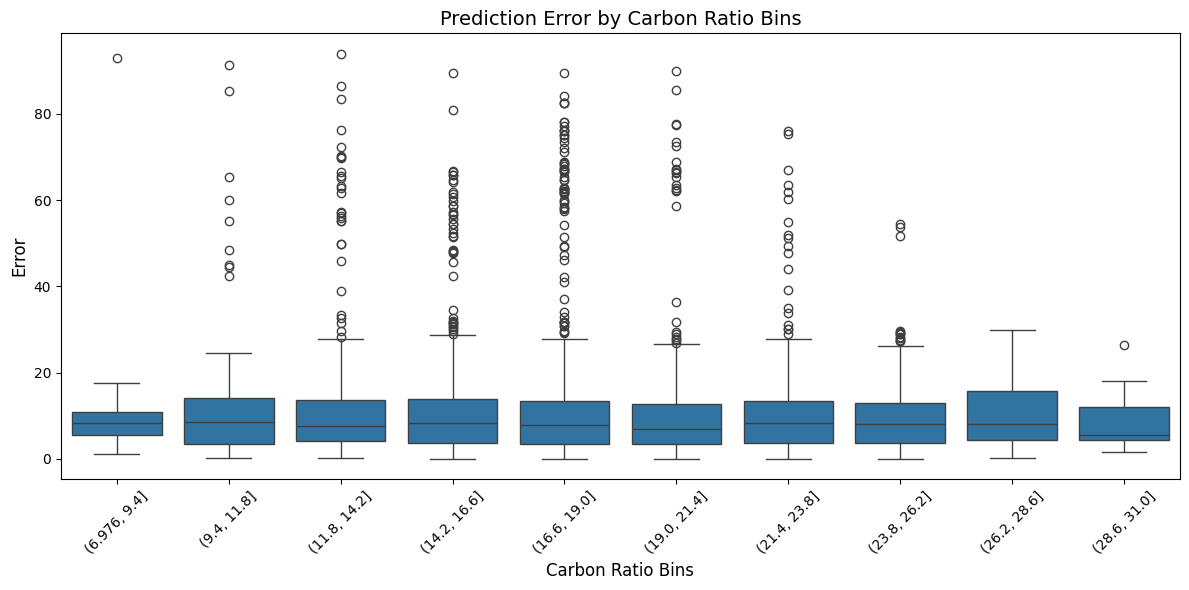

In [66]:
# Plot Error Compared to Carbon-Ratio

test_df['carbon_ratios'] = test_df["Metabolite"].apply(lambda x: x.element_distribution['C'])

test_df["carbon_bin"] = pd.cut(test_df["carbon_ratios"], bins=10)

plt.figure(figsize=(12, 6))
sns.boxplot(data=test_df, x="carbon_bin", y="error")
plt.title("Prediction Error by Carbon Ratio Bins", fontsize=14)
plt.xlabel("Carbon Ratio Bins", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [67]:
def is_element_included(element, metabolite):    # element as symbol
    if element in metabolite.node_elements:
        return True
    else:
        return False

/tmp/ipykernel_2092986/2538906055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['I_included'] = test_df["Metabolite"].apply(lambda x : is_element_included('I', x))


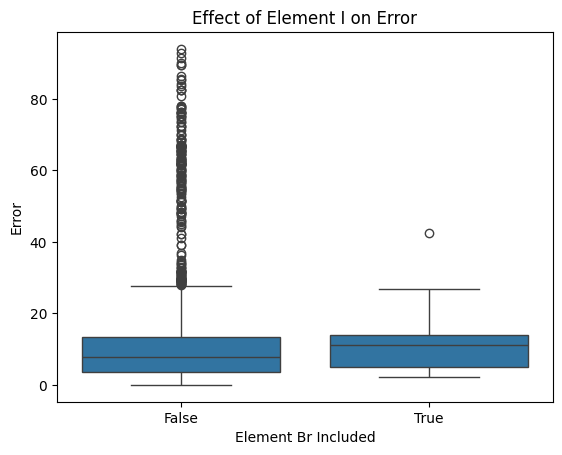

In [68]:
# Plot Error Depending on Iod Existence

test_df['I_included'] = test_df["Metabolite"].apply(lambda x : is_element_included('I', x))

sns.boxplot(data=test_df, x='I_included', y='error')
plt.xlabel("Element Br Included")
plt.ylabel("Error")
plt.title("Effect of Element I on Error")
plt.show()

In [69]:
test_df[test_df['I_included'] == True]

Molecule Name Molecular Formula  \
7784             4-iodo-N,N-bis(prop-2-en-1-yl)benzamide         C13H14INO   
11429  2-(ethylamino)-N-(4-iodo-2-methylphenyl)acetamide        C11H15IN2O   
12251  4-iodo-N-[2-(4-methylpiperidin-1-yl)ethyl]benz...        C15H21IN2O   
13214  N-(4-iodophenyl)-2-[(4-isopropyl-1,2,4-triazol...       C13H15IN4OS   
13316  N-(2-iodophenyl)-1-(4-methylbenzenesulfonyl)py...      C18H19IN2O3S   
16234  N-(5-acetyl-4-phenyl-1,3-thiazol-2-yl)-4-iodob...      C18H13IN2O2S   
18286  N-[(4-carbamoylphenyl)methyl]-N-cyclopropyl-4-...       C18H17IN2O2   
18394  [4-(methoxycarbonyl)phenyl]methyl 2-hydroxy-5-...         C16H13IO5   
22192  2-iodo-N-[2-(4-phenylpiperazin-1-yl)ethyl]benz...        C19H22IN3O   
25023  3-iodo-N-[2-oxo-2-(pyrrolidin-1-yl)ethyl]benza...       C13H15IN2O2   
27140  [4-(methoxycarbonyl)phenyl]methyl 2-hydroxy-5-...         C16H13IO5   
27174  N-(2-iodophenyl)-1-(4-methylbenzenesulfonyl)py...      C18H19IN2O3S   
30717  N-(5-acetyl-4-phenyl-1,3-thiazol-2-yl)-4-iodob...      C18H13IN2O2S   
35097  3-iodo-N-[2-oxo-2-(pyrrolidin-1-yl)ethyl]benza...       C13H15IN2O2   
35798  4-iodo-N-[2-(4-methylpiperidin-1-yl)ethyl]benz...        C15H21IN2O   
38631  N-(4-iodophenyl)-2-[(4-isopropyl-1,2,4-triazol...       C13H15IN4OS   
40530  N-[(4-carbamoylphenyl)methyl]-N-cyclopropyl-4-...       C18H17IN2O2   

       METLIN ID Precursor Adduct    CCS1    CCS2    CCS3  CCS_AVG      % CV  \
7784   1105374.0           [M+H]+  159.86  159.66  159.27   159.60  0.188005   
11429  1111829.0           [M+H]+  164.52  165.31  164.92   164.92  0.239516   
12251  1099788.0           [M+H]+  179.17  179.17  178.39   178.91  0.251709   
13214  1131263.0           [M+H]+  182.20  182.78  183.17   182.72  0.267125   
13316  1177431.0           [M+H]+  189.04  188.08  188.28   188.47  0.268738   
16234  1179751.0           [M+H]+  194.51  193.36  194.32   194.06  0.317669   
18286  1184715.0           [M+H]+  190.15  189.57  188.80   189.51  0.357356   
18394  1172486.0           [M+H]+  240.17  238.48  239.04   239.23  0.359851   
22192  1170761.0           [M+H]+  188.97  188.97  190.51   189.48  0.469242   
25023  1130948.0           [M+H]+  169.28  172.01  169.87   170.39  0.843046   
27140  1172486.0           [M-H]-  182.07  181.49  181.68   181.75  0.162691   
27174  1177431.0           [M-H]-  178.49  178.10  178.68   178.42  0.165728   
30717  1179751.0           [M-H]-  194.41  196.33  195.56   195.43  0.494421   
35097  1130948.0           [M-H]-  177.60  177.01  177.60   177.40  0.192016   
35798  1099788.0           [M-H]-  182.07  182.65  181.88   182.20  0.220156   
38631  1131263.0           [M-H]-  176.60  175.83  175.44   175.96  0.335464   
40530  1184715.0           [M-H]-  194.80  194.61  193.26   194.22  0.432326   

            m/z  ... group_id  num_per_group  loss_weight  \
7784   328.0193  ...     7784              1          1.0   
11429  319.0302  ...    11428              1          1.0   
12251  373.0771  ...    12250              2          0.5   
13214  403.0084  ...    13212              2          0.5   
13316  471.0234  ...    13314              2          0.5   
16234  448.9815  ...    16231              2          0.5   
18286  421.0408  ...    18282              2          0.5   
18394  412.9880  ...    18390              2          0.5   
22192  436.0880  ...    22187              1          1.0   
25023  359.0251  ...    25017              2          0.5   
27140  410.9735  ...    18390              2          0.5   
27174  469.0088  ...    13314              2          0.5   
30717  446.9670  ...    16231              2          0.5   
35097  357.0105  ...    25017              2          0.5   
35798  371.0626  ...    12250              2          0.5   
38631  400.9939  ...    13212              2          0.5   
40530  419.0262  ...    18282              2          0.5   

                                                 summary  \
7784   {'collision_energy': -1, 'instr

Classify Metabolites Based on Murcko Scaffold and Evaluate the Error Rates Depending on These Classes

In [70]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

/tmp/ipykernel_2092986/3133248743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['scaffold'] = test_df['smiles'].apply(lambda x: get_murcko_scaffold(x))
/tmp/ipykernel_2092986/3133248743.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['scaffold'] = test_df['scaffold'].apply(
/tmp/ipykernel_2092986/3133248743.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

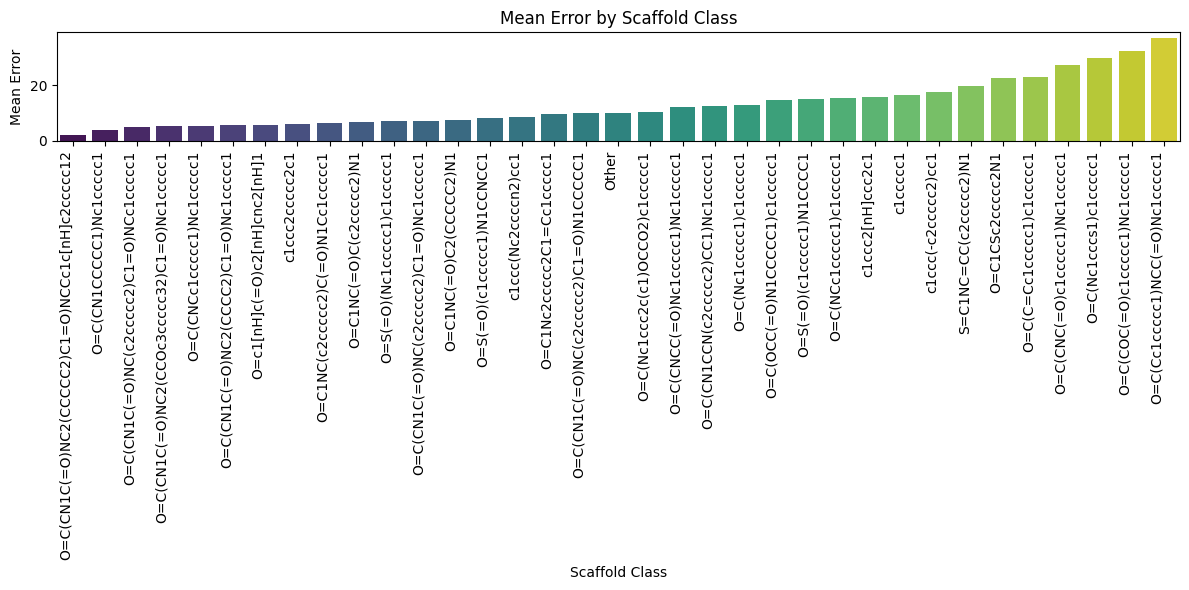

In [71]:
# create scaffold column, group by scaffold, calculate mean error for each scaffold class

test_df['scaffold'] = test_df['smiles'].apply(lambda x: get_murcko_scaffold(x))
scaffold_counts = test_df['scaffold'].value_counts()

# Define a threshold for grouping rare scaffolds
threshold = 5

# Replace rare scaffolds with 'Other'
test_df['scaffold'] = test_df['scaffold'].apply(
    lambda x: x if scaffold_counts[x] > threshold else 'Other'
)

grouped_data = test_df.groupby('scaffold')['error'].mean().reset_index()

grouped_data = grouped_data.sort_values(by='error')

# plot error for each scaffold class
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='scaffold', y='error', palette="viridis")

plt.title("Mean Error by Scaffold Class")
plt.xlabel("Scaffold Class")
plt.ylabel("Mean Error")
plt.xticks(rotation=90, ha='right')  # rotate x-axis labels if there are many scaffolds
plt.tight_layout()
plt.show()

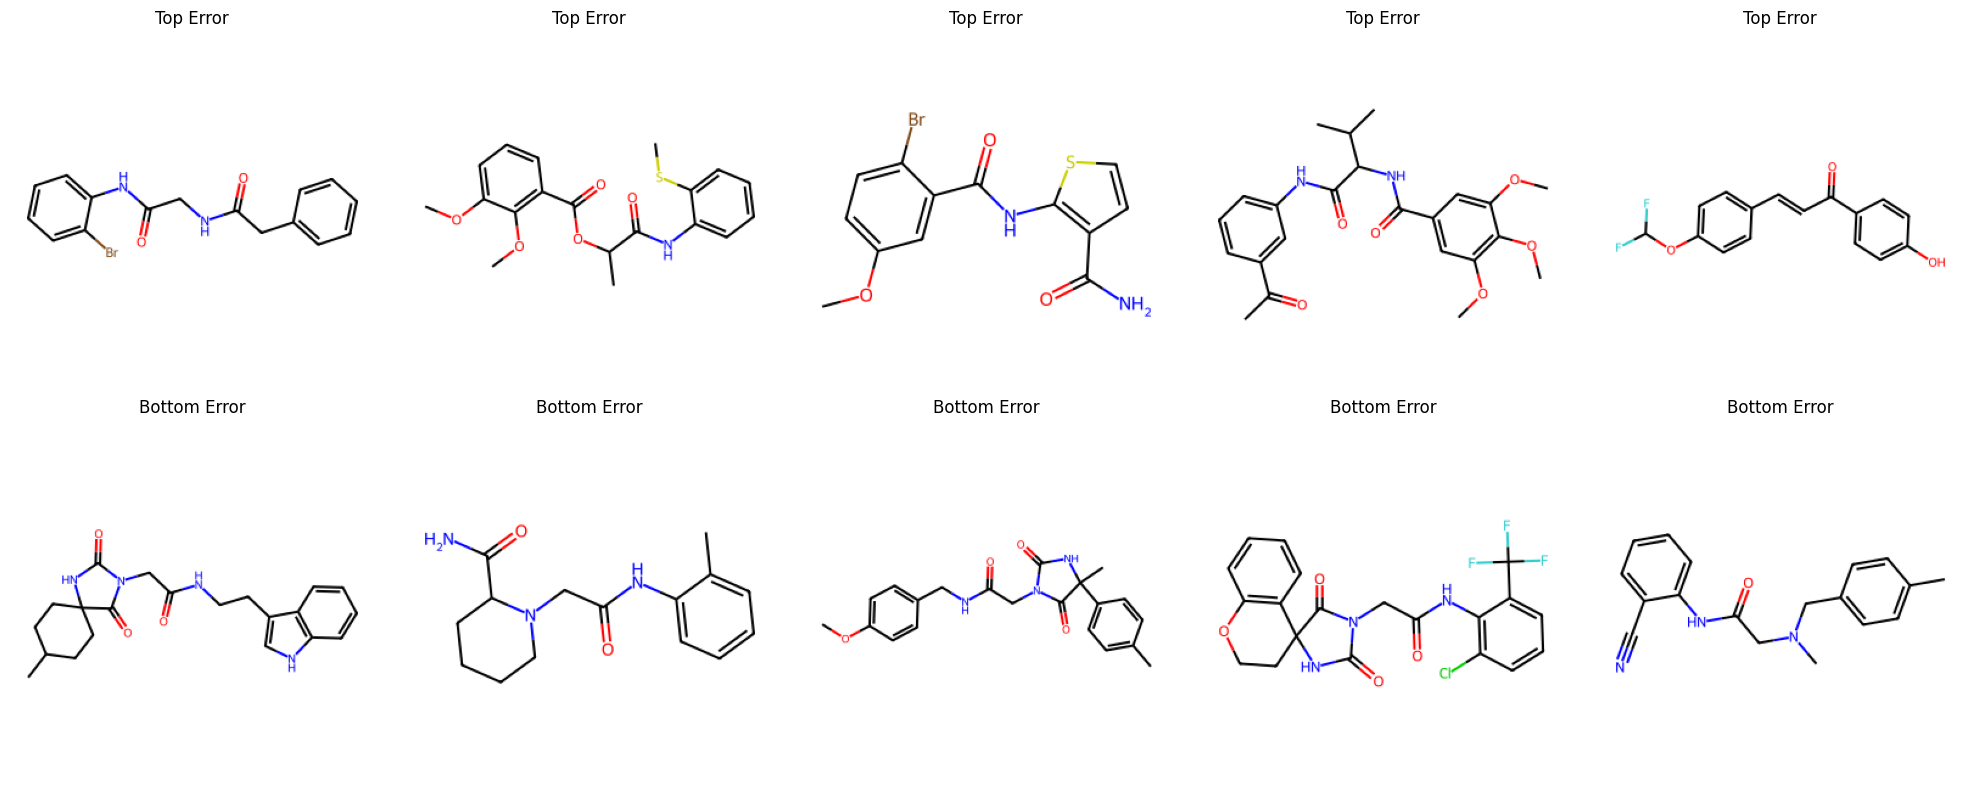

In [72]:
from rdkit.Chem import Draw

# Get the top 5 scaffolds with the highest and lowest errors
top_5_scaffolds = grouped_data.nlargest(5, 'error')['scaffold']
bottom_5_scaffolds = grouped_data.nsmallest(5, 'error')['scaffold']

scaffolds_to_plot = pd.concat([top_5_scaffolds, bottom_5_scaffolds])

# Create a new DataFrame with the corresponding SMILES for top and bottom scaffolds
top_bottom_scaffolds = test_df[test_df['scaffold'].isin(scaffolds_to_plot)]

molecule_images = []

# Create a molecule image for each scaffold in the top 5 and bottom 5
for scaffold in scaffolds_to_plot:
    scaffold_smiles = top_bottom_scaffolds[top_bottom_scaffolds['scaffold'] == scaffold]['smiles'].iloc[0]
    mol = Chem.MolFromSmiles(scaffold_smiles)
    img = Draw.MolToImage(mol)
    molecule_images.append(img)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    if i < 5:
        ax.set_title("Top Error")  # Set title for top 5
    else:
        ax.set_title("Bottom Error")  # Set title for bottom 5
    ax.imshow(molecule_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [73]:
import fiora.MOL.constants

def rare_element_included(metabolite):
    rare_elements = fiora.MOL.constants.RARE_ELEMENTS
    included = False
    for element in rare_elements:
        included = included or is_element_included(element, metabolite)
    return included

/tmp/ipykernel_2092986/2821679205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['rare_element_included'] = test_df["Metabolite"].apply(lambda x : rare_element_included(x))


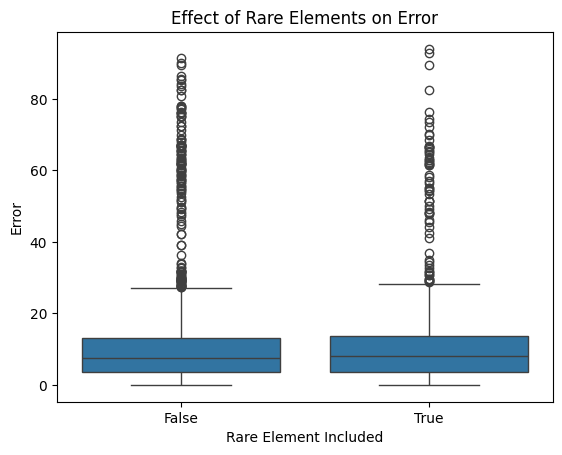

In [74]:
# Plot Error Depending on Rare Element Existence

test_df['rare_element_included'] = test_df["Metabolite"].apply(lambda x : rare_element_included(x))

sns.boxplot(data=test_df, x='rare_element_included', y='error')
plt.xlabel("Rare Element Included")
plt.ylabel("Error")
plt.title("Effect of Rare Elements on Error")
plt.show()

In [75]:
# import torch
# from fiora.GNN.Trainer import Trainer

In [76]:
# loss_fn = torch.nn.MSELoss() 

# rt_epochs = 500 # 300
# rt_batch = 64 #128
# rt_lr = 0.005

# def train_rt_model(rt_lr=rt_lr, rt_batch=rt_batch, rt_epochs=rt_epochs):        
#     y_label = 'compiled_probsALL'
#     optimizer = torch.optim.Adam(model.parameters(), lr=rt_lr)
#     train_keys, val_keys = ccs_df[ccs_df["dataset"] == "training"]["group_id"].unique(), ccs_df[ccs_df["dataset"] == "validation"]["group_id"].unique()
#     trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", train_keys=train_keys, val_keys=val_keys, metric_dict=None, split_by_group=True, seed=seed, device=dev)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 8, factor=0.8, mode = 'min', verbose = True)
#     checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=rt_batch, epochs=rt_epochs, val_every_n_epochs=1, with_CCS=True, with_RT=True, rt_metric=True, masked_validation=False, tag=tag) #, mask_name="compiled_validation_maskALL")   

#     return model, checkpoints

In [77]:
# model.set_dropout_rate(input_dropout=0.5, latent_dropout=0.5)

# model, cp = train_rt_model()

Class PropertyTrainer

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch_geometric.loader as geom_loader
from torchmetrics import Accuracy, MetricTracker, MetricCollection, Precision, Recall, PrecisionRecallCurve, MeanSquaredError, MeanAbsoluteError, R2Score
from sklearn.model_selection import train_test_split
from typing import Literal, List, Callable, Any, Dict

from fiora.GNN.Trainer import Trainer
from fiora.GNN.Datasets import collate_graph_batch, collate_graph_edge_batch
from fiora.GNN.Losses import WeightedMSELoss, WeightedMAELoss

In [ ]:
class PropertyTrainer(Trainer):
    def __init__(self, data: Any, train_val_split: float= 0.8, split_by_group: bool=False, only_training: bool=False, train_keys: List[int]=[], val_keys: List[int]=[], y_tag: str="y", metric_dict: Dict=None, problem_type: Literal["classification", "regression", "softmax_regression"]="classification", library: Literal["standard", "geometric"]="geometric", num_workers: int=0, seed: int=42, device: str="cpu"):
        
        super().__init__(data, train_val_split, split_by_group, only_training, train_keys, val_keys, seed, num_workers, device)
        self.y_tag = y_tag
        self.problem_type = problem_type
        
        # Initialize torch metrics based on dictionary 
        if metric_dict:
            self.metrics = {
                data_split: MetricTracker(MetricCollection({
                        t: M() for t,M in metric_dict.items()
                    })).to(device)
                for data_split in ["train", "val", "masked_val", "test"]
            }
        else:
            self.metrics = self._get_default_metrics(problem_type)
        self.loader_base = geom_loader.DataLoader if library == "geometric" else DataLoader
    
    def _training_loop(self, model, dataloader, optimizer, loss_fn, metrics, rt_metric=False, title=""):
        metrics.increment()       

        for id, batch in enumerate(dataloader):
            # Feed forward
            model.train()
            
            y_pred = model(batch, with_CCS=True)

            if "CCS_pred" not in y_pred or "CCS_pred" not in batch:
                raise KeyError("CCS_pred key missing in model output or batch.")

            if not isinstance(y_pred["CCS_pred"], torch.Tensor) or not isinstance(batch["CCS_pred"], torch.Tensor):
                raise TypeError("Both y_pred['CCS_pred'] and batch['CCS_pred'] must be torch tensors.")

            if y_pred["CCS_pred"].shape != batch["CCS_pred"].shape:
                raise ValueError(f"Shape mismatch: y_pred['CCS_pred']: {y_pred['CCS_pred'].shape}, "
                                f"batch['CCS_pred']: {batch['CCS_pred'].shape}")

            loss = loss_fn(y_pred["CCS_pred"], batch["CCS_pred"])  

            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        

    def _validation_loop(self, model, dataloader, loss_fn, metrics, with_weights=False, with_RT=False,  with_CCS=False, rt_metric=False,  mask_name=None, title="Validation"):
        metrics.increment()
        with torch.no_grad():
            for id, batch in enumerate(dataloader):
                model.eval()
                y_pred = model(batch, with_RT=with_RT, with_CCS=with_CCS) # with_CCS = True
                loss = loss_fn(y_pred["CCS_pred"], batch["CCS_pred"])
                    
                metrics(y_pred["CCS_pred"], batch["CCS_pred"]) # call update                      

        # End of Validation cycle
        stats = metrics.compute()
        print(f'\t{title} RMSE: {torch.sqrt(stats["mse"]):>.4f}')
        return stats
        
        
    # Training function
    def train(self, model, optimizer, loss_fn, scheduler=None, batch_size=16, epochs=2, val_every_n_epochs=1, use_validation_mask=False, with_RT=True, with_CCS=True, rt_metric=False, mask_name="validation_mask", tag="") -> Dict[str, Any]:
        
        # Set up checkpoint system and model info
        self._init_checkpoint_system(save_path=f"../../checkpoint_{tag}.best.pt")
        model.model_params["training_label"] = self.y_tag
        
        # Stage data into dataloader
        training_loader = self.loader_base(self.training_data, batch_size=batch_size, num_workers=self.num_workers, shuffle=True)
        if not self.only_training:
            validation_loader = self.loader_base(self.validation_data, batch_size=batch_size, num_workers=self.num_workers, shuffle=True)
        using_weighted_loss_func = isinstance(loss_fn, WeightedMSELoss) | isinstance(loss_fn, WeightedMAELoss)
        
        # Main loop
        for e in range(epochs):
            
            # Training
            self._training_loop(model, training_loader, optimizer, loss_fn, self.metrics["train"], title=f'Epoch {e + 1}/{epochs}: ', with_weights=using_weighted_loss_func, with_RT=with_RT, with_CCS=with_CCS, rt_metric=rt_metric)
            
            # Validation
            is_val_cycle = not self.only_training and ((e + 1) % val_every_n_epochs == 0)
            if is_val_cycle:   
                val_stats = self._validation_loop(model, validation_loader, loss_fn, self.metrics["masked_val"] if use_validation_mask else self.metrics["val"], with_weights=using_weighted_loss_func, with_RT=with_RT, with_CCS=with_CCS, rt_metric=rt_metric, mask_name=mask_name if use_validation_mask else None, title="Masked Validation" if use_validation_mask else "Validation")
                
                # Update checkpoint
                if val_stats["mse"].tolist() < self.checkpoint_stats["val_loss"]:
                    self._update_checkpoint({"epoch": e+1, "val_loss": val_stats["mse"].tolist()}, model)
                    print(f"\t >> Set new checkpoint to epoch {e+1}")
            
            # End of epoch: Advance scheduler
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    if is_val_cycle:
                        scheduler.step(torch.sqrt(val_stats["mse"]))
                else:
                    scheduler.step()
                    
        print("Finished Training!")
        return self.checkpoint_stats
    